<center><h1>Deep Calibration</h1></center>
<h2>Students:</h2>
<h3><font color="red">Issame SARROUKH</font></h3>
<h3><font color="red">Ouassim SEBBAR</font></h3>

We train the neural network model on Google Cloud Platform with a P100 Nvidia GPU

edit: now on a local machine with GTX 1070 GPU

We modified some part of the code to facilitate testing the models.

In [10]:
import numpy as np

x = np.loadtxt( 'expOUx.txt' )
y = np.loadtxt( 'expOUy.txt' )

In [11]:
# examine maturities and strikes 
for i in range(4,6):
    print(i,":", *np.unique(x[:, i]), sep="\t")

4	:	0.1	0.3	0.6	0.9	1.2	1.5	1.8	2.0
5	:	0.5	0.6	0.7	0.8	0.9	1.0	1.1	1.2	1.3	1.4	1.5


In [12]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing   import StandardScaler
# divide into train and test data and add indices to identify the position of each change due to the split 
indices = np.arange(x.shape[0])
X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split( x, y, indices, test_size = 0.15, random_state = 42 )
# apply standard scaler 
scale             = StandardScaler()
scale2            = StandardScaler()
# center and normalize data and save mean and standard dev
y_train_transform = scale.fit_transform( y_train.reshape( -1, 1 ) )
y_test_transform  = scale.transform( y_test.reshape( -1, 1 ) )
x_train_transform = scale2.fit_transform( X_train )
x_test_transform  = scale2.transform( X_test )

In [13]:
# vectorize the scaling method 
ub = [ 0.16,   4, 10,  0, 2.0, 1.5 ]
lb = [ 0.01, 0.5,  0, -1, 0.1, 0.5 ]
ub = np.array(ub).reshape(1, -1)
lb = np.array(lb).reshape(1, -1)

In [18]:
# scaling data 
def mScale(x): 
    res = (x-(ub + lb)*0.5)*2. /(ub-lb)
    return res
# inverse scaling
def mInverse(x): 
    res = x*(ub - lb)*0.5 + (ub + lb)*0.5
    return res

In [19]:
x_train_transform = mScale(X_train)
x_test_transform = mScale(X_test)

In [20]:
# verify the validity of the scaling
mInverse(x_train_transform)

array([[ 0.0823352,  0.766057 ,  5.34238  , -0.173578 ,  0.9      ,
         1.3      ],
       [ 0.0327409,  3.75799  ,  3.44087  , -0.419138 ,  2.       ,
         1.3      ],
       [ 0.156257 ,  3.12379  ,  6.32522  , -0.933201 ,  0.9      ,
         1.2      ],
       ...,
       [ 0.137243 ,  2.78388  ,  2.36757  , -0.682835 ,  0.3      ,
         1.4      ],
       [ 0.148645 ,  0.666213 ,  4.43626  , -0.842044 ,  2.       ,
         1.1      ],
       [ 0.133304 ,  1.94026  ,  3.3354   , -0.413884 ,  2.       ,
         0.6      ]])

In [21]:
X_train

array([[ 0.0823352,  0.766057 ,  5.34238  , -0.173578 ,  0.9      ,
         1.3      ],
       [ 0.0327409,  3.75799  ,  3.44087  , -0.419138 ,  2.       ,
         1.3      ],
       [ 0.156257 ,  3.12379  ,  6.32522  , -0.933201 ,  0.9      ,
         1.2      ],
       ...,
       [ 0.137243 ,  2.78388  ,  2.36757  , -0.682835 ,  0.3      ,
         1.4      ],
       [ 0.148645 ,  0.666213 ,  4.43626  , -0.842044 ,  2.       ,
         1.1      ],
       [ 0.133304 ,  1.94026  ,  3.3354   , -0.413884 ,  2.       ,
         0.6      ]])

In [45]:
import tensorflow as tf

tf.keras.backend.set_floatx( 'float64' )
input1  = tf.keras.layers.Input( shape = ( 6, ) )
neurons = 2 ** 5
hlayers = 2
nn      = [ 0. ] * ( 1 + hlayers + 1 )
nn[ 0 ] = input1
for l in range( 1, hlayers + 1 ):
    nn[ l ] = tf.keras.layers.Dense( neurons, activation = 'relu' )( nn[ l - 1 ] ) 
# uncomment to add dropout layer
# nn[-2]    =  tf.keras.layers.Dropout(0.5)(nn[-2])
nn[ -1 ] = tf.keras.layers.Dense( 1, activation = 'linear' )( nn[ -2 ] )

model = tf.keras.models.Model( inputs = nn[ 0 ], outputs = nn[ -1 ] )
model.summary()

Model: "model_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_6 (InputLayer)         [(None, 6)]               0         
_________________________________________________________________
dense_13 (Dense)             (None, 32)                224       
_________________________________________________________________
dense_14 (Dense)             (None, 32)                1056      
_________________________________________________________________
dense_15 (Dense)             (None, 1)                 33        
Total params: 1,313
Trainable params: 1,313
Non-trainable params: 0
_________________________________________________________________


In [124]:
# remove quotates to try batch normalisation
"""
import tensorflow as tf

tf.keras.backend.set_floatx( 'float64' )
input1  = tf.keras.layers.Input( shape = ( 6, ) )
neurons = 2 ** 5
hlayers = 3
nn      = [ 0. ] * ( 1 + hlayers + 1 )
nn[ 0 ] = input1
nn[1] = tf.keras.layers.BatchNormalization()(nn[0]) 
for l in range( 1, hlayers + 1 ):
    nn[ l ] = tf.keras.layers.Dense( neurons)( nn[ l - 1 ] )
    nn[l] = tf.keras.layers.BatchNormalization()(nn[l]) 
    nn[l] = tf.keras.layers.Activation("elu")(nn[l]) 
nn[ -1 ] = tf.keras.layers.Dense( 1, activation = 'linear' )( nn[ -2 ] )

model = tf.keras.models.Model( inputs = nn[ 0 ], outputs = nn[ -1 ] )
model.summary()
"""

Model: "model_15"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_20 (InputLayer)        [(None, 6)]               0         
_________________________________________________________________
dense_57 (Dense)             (None, 32)                224       
_________________________________________________________________
batch_normalization_11 (Batc (None, 32)                128       
_________________________________________________________________
activation_3 (Activation)    (None, 32)                0         
_________________________________________________________________
dense_58 (Dense)             (None, 32)                1056      
_________________________________________________________________
batch_normalization_12 (Batc (None, 32)                128       
_________________________________________________________________
activation_4 (Activation)    (None, 32)                0  

In [46]:
%%time
# above: assess the execution time of the cell
from tensorflow.keras.callbacks import EarlyStopping
def root_mean_squared_error( y_true, y_pred ):
    return tf.keras.backend.sqrt( tf.keras.backend.mean( tf.keras.backend.square( y_pred - y_true ) ) )

epochs = 256
lr =10**-4
# we add early stopping in case the model doesn't improve
es = EarlyStopping(monitor='val_loss', mode='min', verbose=1, patience=10)
opt    = tf.keras.optimizers.Adam( learning_rate = lr )
model.compile( loss = root_mean_squared_error, optimizer = opt )
history = model.fit( x_train_transform, y_train_transform,
                    batch_size =128, validation_data = ( x_test_transform, y_test_transform ),
                    epochs = epochs, verbose = True, shuffle = 1 , callbacks=[es])


Epoch 1/256
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function root_mean_squared_error at 0x000001E2976A5318>. Note that functions defined in certain environments, like the interactive Python shell do not expose their source code. If that is the case, you should to define them in a .py source file. If you are certain the code is graph-compatible, wrap the call using @tf.autograph.do_not_convert. Original error: could not get source code
To silence this warning, decorate the function with @tf.autograph.experimental.do_not_convert
Please report this to the TensorFlow team. When filing the bug, set the verbosity to 10 (on Linux, `export AUTOGRAPH_VERBOSITY=10`) and attach the full output.
Cause: Unable to locate the source code of <function root_mean_squared_error at 0x000001E2976A5318>. Note that functions defined in certain env

2904/2904 [==============================] - 4s 1ms/step - loss: 0.0328 - val_loss: 0.0326
Epoch 65/256
2904/2904 [==============================] - 4s 1ms/step - loss: 0.0331 - val_loss: 0.0316
Epoch 66/256
2904/2904 [==============================] - 4s 1ms/step - loss: 0.0331 - val_loss: 0.0315
Epoch 67/256
2904/2904 [==============================] - 4s 1ms/step - loss: 0.0330 - val_loss: 0.0316
Epoch 68/256
2904/2904 [==============================] - 4s 1ms/step - loss: 0.0325 - val_loss: 0.0316
Epoch 69/256
2904/2904 [==============================] - 4s 1ms/step - loss: 0.0322 - val_loss: 0.0314
Epoch 70/256
2904/2904 [==============================] - 4s 1ms/step - loss: 0.0323 - val_loss: 0.0317
Epoch 71/256
2904/2904 [==============================] - 4s 1ms/step - loss: 0.0316 - val_loss: 0.0311
Epoch 72/256
2904/2904 [==============================] - 4s 1ms/step - loss: 0.0320 - val_loss: 0.0312
Epoch 73/256
2904/2904 [==============================] - 4s 1ms/step - loss:

2904/2904 [==============================] - 4s 1ms/step - loss: 0.0293 - val_loss: 0.0282
Epoch 143/256
2904/2904 [==============================] - 4s 1ms/step - loss: 0.0288 - val_loss: 0.0281
Epoch 144/256
2904/2904 [==============================] - 4s 1ms/step - loss: 0.0286 - val_loss: 0.0279
Epoch 145/256
2904/2904 [==============================] - 4s 1ms/step - loss: 0.0291 - val_loss: 0.0283
Epoch 146/256
2904/2904 [==============================] - 4s 1ms/step - loss: 0.0290 - val_loss: 0.0279
Epoch 147/256
2904/2904 [==============================] - 4s 1ms/step - loss: 0.0284 - val_loss: 0.0280
Epoch 148/256
2904/2904 [==============================] - 4s 1ms/step - loss: 0.0288 - val_loss: 0.0281
Epoch 149/256
2904/2904 [==============================] - 4s 1ms/step - loss: 0.0289 - val_loss: 0.0280
Epoch 150/256
2904/2904 [==============================] - 4s 1ms/step - loss: 0.0291 - val_loss: 0.0278
Epoch 151/256
2904/2904 [==============================] - 4s 1ms/ste

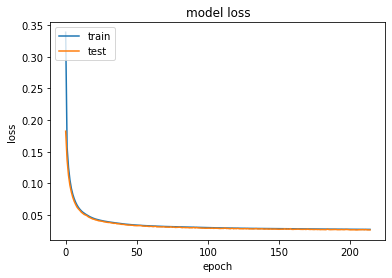

In [47]:
# plot the loss from training history 
import matplotlib.pyplot as plt
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.savefig("loss.png")

In [48]:
# number of training samples 
shape = len(y)
import matplotlib.pyplot as plt

# keep the same format for y even for training and testing data 
def change(y, indices=None):
    if indices is None: 
        return y 
    assert len(y) == len(indices)
    ynew = np.empty(shape)
    ynew[:] = np.nan 
    ynew[indices] = y
    return ynew 
        

def predict(x, y, indices=None):
    errors = np.empty((8, 11))
    
    X = mScale(x)
    ypred = model.predict(X)
    ypred = scale.inverse_transform(ypred )
    ypred = ypred.squeeze()
    ypred = change(ypred, indices=indices)
    ytrue = change(y, indices=indices)
    # a simple transformation to obtain volatilites associated with a fixed strike and maturity
    ypred = ypred.reshape(-1, 8, 11)
    ytrue = ytrue.reshape(-1, 8, 11)

    
    return ypred, ytrue

In [49]:
# nanmean to make sure a score is returned even if observations are not available for a specific strike 
def mae(ytrue, ypred):
    return np.nanmean(np.abs(ypred - ytrue), axis=0)

# relative absolute error can not be calculated for null value so we replace zéros by a null value 
def rae(ytrue, ypred):
    ycopy = ytrue.copy()
    ycopy[ycopy==0] = np.nan
    mean = np.nanmean(np.abs(((ycopy - ypred)/ycopy)), axis=0)
    return 100*mean

# compute the maximum error 
def max_rae(ytrue, ypred):
    ycopy = ytrue.copy()
    ycopy[ycopy==0] = np.nan
    return 100*np.nanmax(np.abs(((ycopy - ypred)/ycopy)), axis=0)

# compute the standard deviation
def std_rae(ytrue, ypred):
    ycopy = ytrue.copy()
    ycopy[ycopy==0] = np.nan
    std = np.nanstd(np.abs(((ycopy - ypred)/ycopy)), axis=0)
    return 100*std

In [50]:
# import some usefull libraries 
from seaborn import heatmap 
import pandas as pd 

In [51]:
# plot heatmap error 
def heatmap_error(ytrue, ypred, scorer, ax, title='plot', percentage=False ):
    # add or not a bar with percentages  
    cbar_kws = dict()
    if percentage: 
        cbar_kws["cbar_kws"] = {'format': '%.0f%%'}
    errors = scorer(ytrue, ypred)
    # compute the error in the correct order 
    errors = pd.DataFrame(errors, columns=[np.unique(x[:, 5])], index=[np.unique(x[:, 4])])
    heatmap(errors,cmap='coolwarm', annot=True, ax=ax, **cbar_kws)
    ax.set_xlabel("Strike")
    ax.set_ylabel("Maturity")
    ax.set_title(title)

In [52]:
# save plot to path 
def savefig(x, y, indices=None, path="fig.png"):
    ypred, ytrue = predict(x, y, indices=indices) 
    fig, axs = plt.subplots(2, 2, figsize=(20, 20))
    titles = ["Mean absolute error", "Relative absolute error", "Max relative absolute error", "Std relative absolute error"]
    perc = [False, True, True, True]
    for index, (scorer, title, p) in enumerate(zip((mae, rae, max_rae, std_rae), titles, perc)):
        heatmap_error(ytrue, ypred, scorer, ax=axs[index//2, index%2], title=title, percentage=p)
    fig.savefig(path)

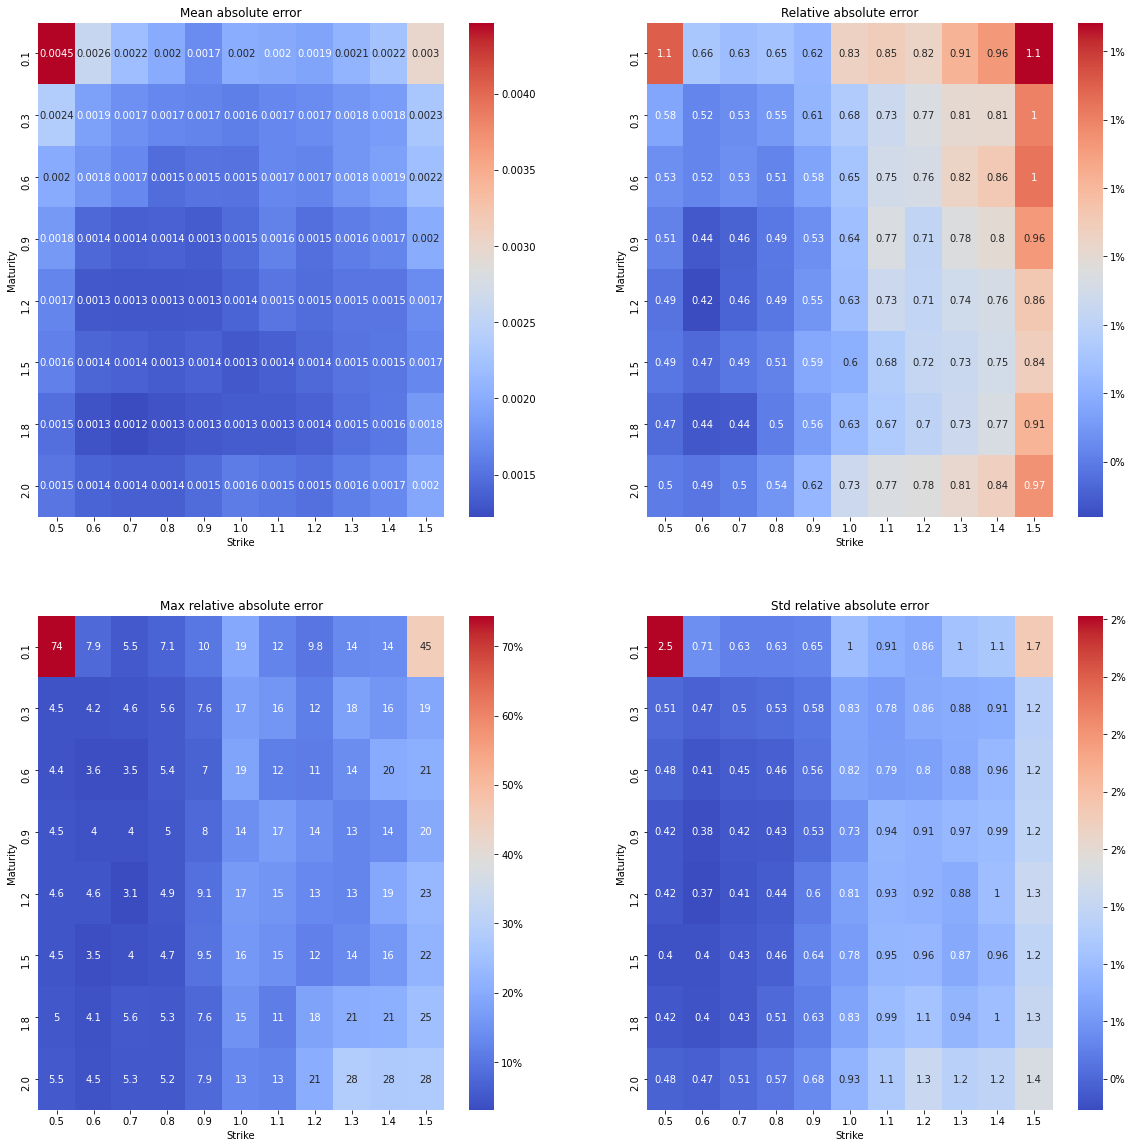

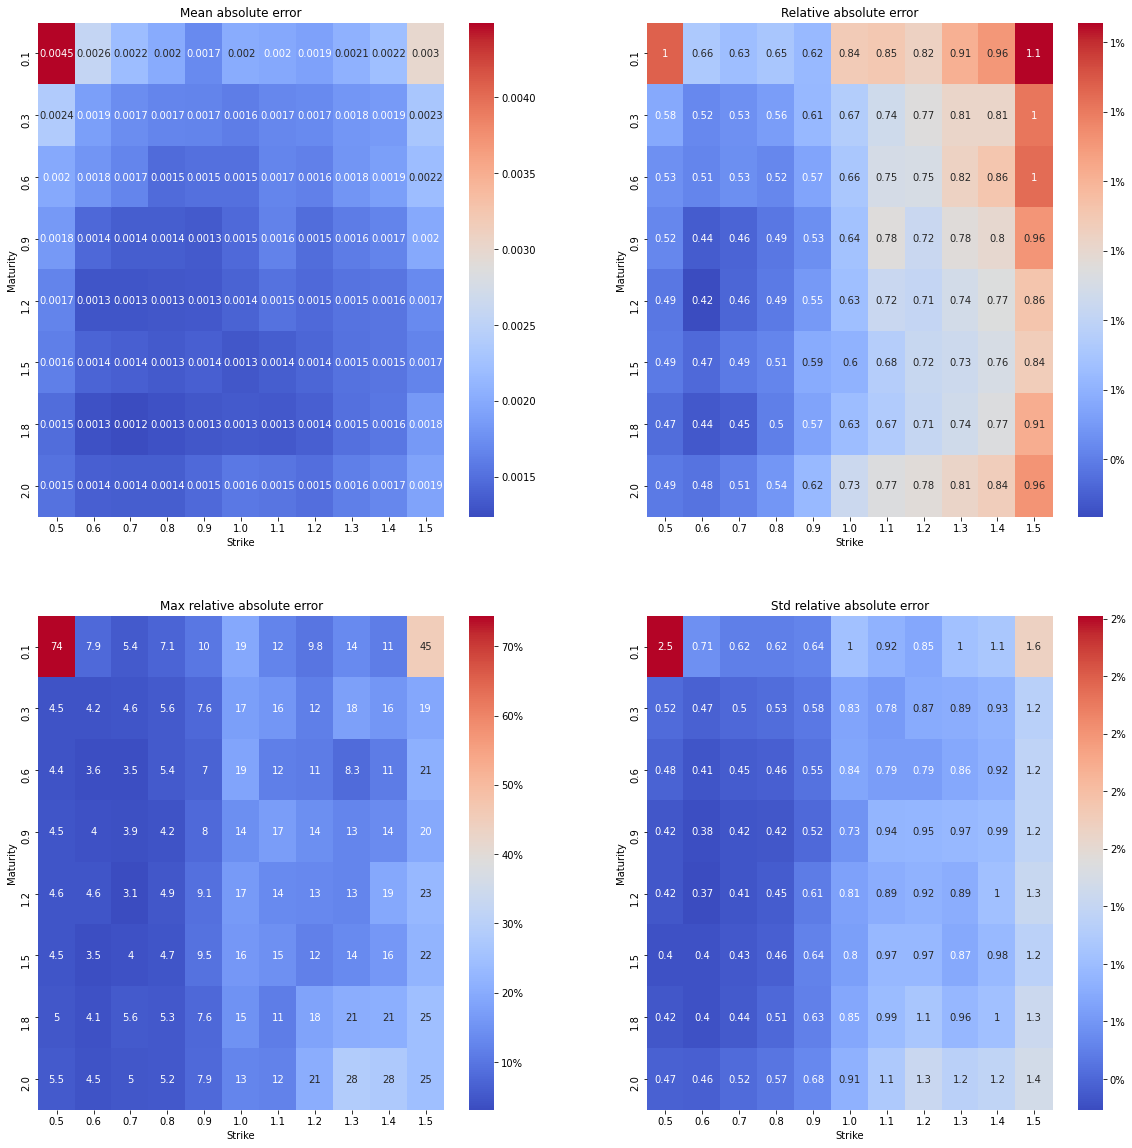

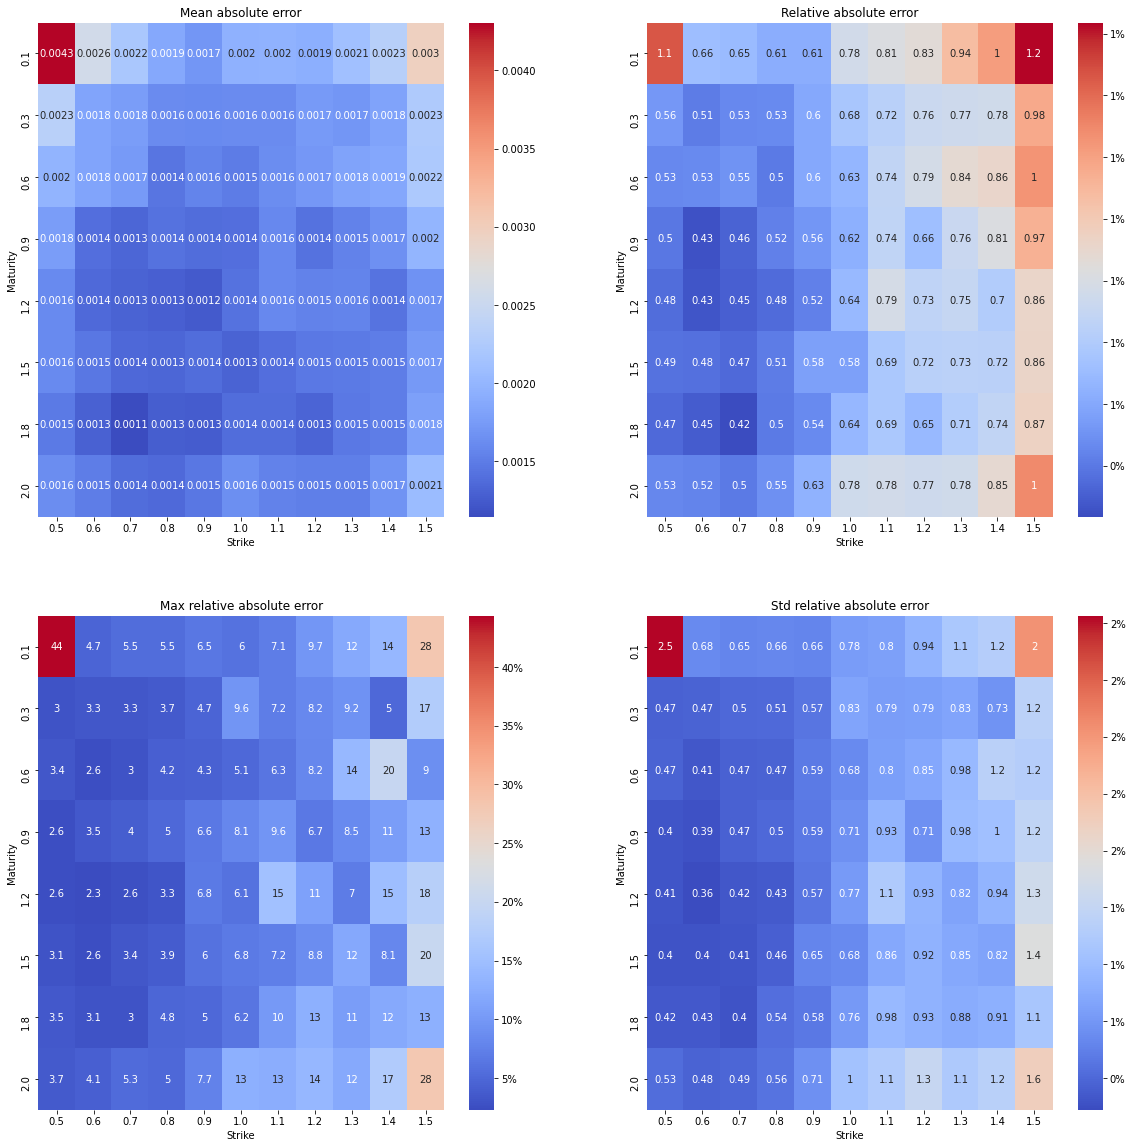

In [54]:
# score are calculated either on: the whole data, training data or testing data
names = ["all", "train", "test"]
# naming the returned plots 
paths = ["fig.png", "figtrain.png", "figtest.png"]
# indices to identify train and test observations 
indices = [None, indices_train, indices_test]
# features
list_X = [x, X_train, X_test]
# output
list_y = [y, y_train, y_test]
for name, path, indices, xi, yi in zip(names, paths, indices, list_X, list_y):
    savefig(xi, yi, indices = indices, path=path)